$$ \\ $$
2.1:
$$ \\ $$
When using an $\epsilon$-greedy action selection criterion, in the case of two actions and $\epsilon = 0.5$, actions would be selected at random half of the time.  Of the times when actions are selected at random, the greedy action will be select half of the time.  Meaning the greedy action will be selected a total of $75\%$ of the time.
$$ \\ $$
2.2:
$$ \\ $$
Given that all of the reward estimates are initialized to 0, the first action will be selected arbitrarily, possible at random.
$$ \\ $$
The following actions must have been selected at random as a result of the $\epsilon$ case: $A_2$, $A_5$.
$$ \\ $$
This can be demonstrated by observing that $Q_1(1) = 1 > Q_1(2) = 0$ and $Q_4(2) = \frac{R_2 + R_3 + R_4}{3} = \frac{5}{3} > Q_4(3) = 0$.
$$ \\ $$
Regarding the question of when random $\epsilon$ selection could have occured, it could have occured at any time step after the first.
$$ \\ $$
2.3:
$$ \\ $$
In the long run $\epsilon=0.01$ will achieve the highest cumulative reward and probability of selecting the correct answer.  The disadvantage of $\epsilon=0.01$ relative to $\epsilon=0.1$ is that it will cause our agent to take longer to find the optimal action, but it will select that action more consistently once it has been found.
$$ \\ $$
The optimal action has a reward of $1.55$. The expected reward per action once the agent has found the best possible action is equal to the sum of the greedy case and the $\epsilon$ random case:  $1.55 (1 - \epsilon) + \epsilon \sum^{10}_{i=1}\frac{q_*(i)}{10}$.
$$ \\ $$
So the difference between the expected long term reward per action in the $\epsilon = .01$ and $\epsilon = .1$ cases is $1.55(.1 - .01) = 0.1395$.
$$ \\ $$
2.4:
$$ \\ $$
If $\alpha$ is not constant, but instead varies with with each update step $n$, then our incremental update rule utilizing $\alpha_n$ can be expressed as follows:
$$ \\ $$
\begin{align} 
Q_{n+1} & = Q_n + \alpha_n [R_n - Q_n] \\
& = \alpha_n R_n + (1 - \alpha_n) Q_n \\
& = \alpha_n R_n + (1 - \alpha_n) (\alpha_{n-1}R_{n-1} + (1 - \alpha_{n-1})Q_{n-1})  \\
& = \alpha_n R_n + (1 - \alpha_n)\alpha_{n-1} R_{n-1} + (1 - \alpha_n)(1 - \alpha_{n-1})(Q_{n-2} + \alpha_{n-2}[R_{n-2} - Q_{n-2}]) \\
& = \alpha_n R_n + (1 - \alpha_n)\alpha_{n-1} R_{n-1} + (1 - \alpha_n)(1 - \alpha_{n-1})((1 - \alpha_{n-2})Q_{n-2} + \alpha_{n-2}R_{n-2})) \\
& = \alpha_n R_n + (1 - \alpha_n)\alpha_{n-1} R_{n-1} + (1 - \alpha_n)(1 - \alpha_{n-1})\alpha_{n-2}R_{n-2} +  \\ 
& ...  +  Q_1 \prod_{i=1}^n(1 - \alpha_i) + \alpha_{1} R_1 \prod_{j = 1}^{n - 1} (1 - \alpha_{n - j + 1}) \\
& = Q_1 \prod_{i=1}^n(1 - \alpha_i) + \sum^{n}_{i = 1}\alpha_{i} R_i \prod_{j = 1}^{n - i} (1 - \alpha_{n - j + 1}) \end{align}
$$ \\ $$
2.5:

In [5]:
%matplotlib inline

import numpy as np
import random
import math
import numpy.random
from enum import Enum
import matplotlib.pyplot as plt

# EXERCISE 2.5

runs = 2000

methods = Enum("BanditMethod", "SAMPLE_AVERAGE EPSILON_GREEDY UCB GRADIENT_BANDIT OPTIMISTIC_GREEDY")

"""
returns data in the format

{
    "rewards": np.array([1.5, .2, ...]),
    "optimal": np.array([1, 0, ...])
}
""" 
def ten_armed_bandit(steps, method = methods.EPSILON_GREEDY, constant_alpha = .1, Q0 = 0.0, c = 0, epsilon = .1):
    q = np.zeros(10, dtype = np.dtype("float64"))
    
    if method == methods.GRADIENT_BANDIT:
        H = np.zeros(10, dtype = np.dtype("float64"))
        
        def prob_A(a):
            return (math.e ** H[j])/sum(list(map(lambda H_a: math.e ** H_a, H)))
            
    else:    
        Q = np.array(list(map(lambda x : Q0, range(10))), dtype = np.dtype("float64"))
        
    N_a = np.zeros(10)
    
    rewards = []
    optimal = []

    for i in range(steps):
        arg_max_reward = None
        arg_max_actions = []

        for j in range(len(q)):
            if method == methods.UCB:
                N_a[j] = N_a[j] + 1
                estimated_reward = Q[j] + c * ((math.log(i + 1)/N_a[j])**.5)
            elif method == methods.GRADIENT_BANDIT:
                estimated_reward = prob_A(j)
            else:
                estimated_reward = Q[j]

            if arg_max_reward == None or estimated_reward > arg_max_reward:
                arg_max_reward = estimated_reward
                arg_max_actions = [j]

            elif estimated_reward == arg_max_reward:
                arg_max_actions.append(j)

        if (method in [methods.SAMPLE_AVERAGE, methods.EPSILON_GREEDY]) and random.uniform(0, 1) < epsilon:
            selected_action = random.choice(range(10))
        else:
            selected_action = random.choice(arg_max_actions)
                    
        actual_reward = q[selected_action]
        was_action_optimal = 1 if actual_reward == max(q) else 0
            
        rewards.append(actual_reward)
        optimal.append(was_action_optimal)
       
        if method == methods.GRADIENT_BANDIT:
            average_reward = sum(rewards) / len(rewards)
            
            for j in range(10):
                if j == selected_action:
                    H[j] = H[j] + constant_alpha * (actual_reward - average_reward) * (1 - prob_A(j))
                else:
                    H[j] = H[j] - constant_alpha * (actual_reward - average_reward) * prob_A(j)
            
        else:
            alpha = 1/(i + 1) if (method in [methods.SAMPLE_AVERAGE, methods.UCB, methods.GRADIENT_BANDIT]) else constant_alpha
            Q[selected_action] = Q[selected_action] + alpha * (actual_reward - Q[selected_action])
        
        random_walk_values = np.random.normal(0, .01, len(q))
        q = q + random_walk_values
                 
    return {
        "rewards": np.array(rewards),
        "optimal": np.array(optimal)
    }


def average_bandit_results(sample_average = False, steps = 10000):
    rewards = np.zeros(steps)
    optimal = np.zeros(steps)
    method = methods.SAMPLE_AVERAGE if sample_average else methods.EPSILON_GREEDY 
    
    for i in range(runs):
        results = ten_armed_bandit(steps, method = method)
        rewards = rewards + (results["rewards"] / runs)
        optimal = optimal + (results["optimal"] / runs)    
    
    return {
        "rewards": rewards,
        "optimal": optimal
    }

def plot_average_rewards(with_sample_average, without_sample_average):
    plt.plot(with_sample_average, "r--", label = "sample average")
    plt.plot(without_sample_average, "g", label = "constant")
    plt.xlabel("steps")
    plt.ylabel("average reward")
    plt.legend()
    plt.show()
    
def plot_average_optimality(with_sample_average, without_sample_average):
    plt.plot(with_sample_average, "r--", label = "sample average")
    plt.plot(without_sample_average, "g", label = "constant")
    plt.xlabel("steps")
    plt.ylabel("percent optimal")
    plt.legend()
    plt.show()

In [ ]:
with_sample_average = average_bandit_results(True)

In [148]:
without_sample_average = average_bandit_results()

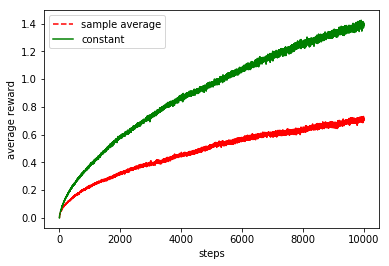

In [149]:
plot_average_rewards(with_sample_average["rewards"], without_sample_average["rewards"])

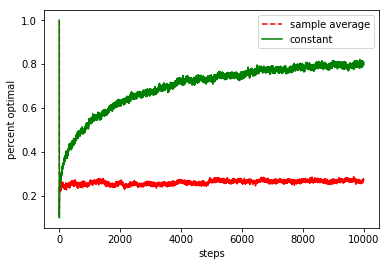

In [150]:
plot_average_optimality(with_sample_average["optimal"], without_sample_average["optimal"])

We can observe above that the sample average method performs poorly for non-stationary reward distributions.

2.6: 
$$ \\ $$
The optimistic greedy agent's initial spike in rewards can be explained as follows.
$$ \\ $$
$q_{*}(a)$ is normally distributed with a mean of $0$ and a variance of $1$.  This means $Q_1 > max\{q_{*}(a)\}$ in the vast majority of cases.  
$$ \\ $$
For the reward distributions where the above is true, agents with the optimistic greedy action-value method will attempt every action at least once at the onset.  
$$ \\ $$
The spike we observe is a product of agents selecting the optimal action once during this preliminary period.
$$ \\ $$
2.7:
$$ \\ $$
$$ \overline{o}_n = \alpha \sum_{i=1}^n (1 - \alpha)^{i-1} \ $$
$$ \beta_n = \frac{1}{\sum_{i=0}^n (1 - \alpha)^{i-1}} $$
FIXME
show that Q n + 1, equivalent of equation 2.6 that the. can use answer from 2.4
$$ \\ $$
2.8:
$$ \\ $$
FIXME
$$ \\ $$
2.9:
$$ \\ $$
The softmax distribution with two actions consist of,
$$ \\ \pi_t(a) = \frac{e^{H_t(a)}}{e^{H_t(1)} + e^{H_t(2)}}. \\ $$
Logistic classifiers are binary classifiers.  In this case let $L(a)$ represent the probability assigned by a logistic classifier of selecting $a$, where $a \in \{ 1 , 2 \}$.  $L(2)$ is formulated as,
$$ \\ L(2) = \frac{1}{1+ e^{- f(2)} } \\ $$
where $f(a)$ is a function which accepts an action and outputs a preference score.  In the case of the softmax distribution, the probability of selection action $a=2$ is,
\begin{align}
\pi_t(2) &= \frac{e^{H_t(2)}}{e^{H_t(1)} + e^{H_t(2)}} \\
&= \frac{1}{1 + e^{H_t(1) - H_t(2)}}. 
\end{align}
Now let $f(a)$ be a function which outputs a preference score such that $f(2) = -(H_t(1) - H_t(2))$, so $\pi_t(2)$ can be re-expressed as,
$$ \\ \pi_t(2) = \frac{1}{1 + e^{-f(2)}} = L(2). \\ $$ 
The above equality demonstrates the equivalence of logistic classifiers and the softmax distributions with two actions, or classes.
$$ \\ $$
2.10:
$$ \\ $$
We are presented with a 2-armed bandit problem, and our two actions vary between two sets of reward values for scenario $A$ and scenario $B$, $Q_A(1) = .1$, $Q_B(2) = .2$, and $Q_B(1) = .9$, $Q_B(2) = .8$, where both scenarios occur with a probability of $.5$.
$$ \\ $$
In the case that we are unable to determine what scenario we are in, the expected reward of each action is,
$$ Q(a) = \frac{Q_A(a) + Q_B(a)}{2} \\ $$
In this case $Q(1) = Q(2) = .5$. The expected rewards are the same for both action, meaning we can achieve the best possible result of $.5$ by picking actions arbitrarily, possible at random.
$$ \\ $$
In the case that we are told at each time step whether we are facing scenario A or scenario B, we should select action $a=2$ in scenario A, and action $a=1$ in scenario B. So the average reward at each time step will be,
$$ Q = \frac{Q_A(2) + Q_B(1)}{2} = .55 $$



In [16]:
# EXERCISE 2.11

def compare_bandits_parameters(steps = 200000):
    # epsilon greedy varied over epsilon
    # ucb varied over c
    # gradient bandit varied over alpha
    # optimistic epsilon greedy varied over Q0
    average_range = int((steps / 2) - 1)
    epsilon_greedy = []
    optimistic_greedy = []
    ucb = []
    gradient_bandit = []
    
    for i in range(10): 
        parameter_value = 2 ** (i - 7)
        
        if parameter_value < 1:
            epsilon_greedy.append(np.average(ten_armed_bandit(steps, epsilon = parameter_value)["rewards"][average_range:]))
        else:
            epsilon_greedy.append(0)
        
        optimistic_greedy.append(np.average(ten_armed_bandit(steps, Q0 = parameter_value, method = methods.OPTIMISTIC_GREEDY)["rewards"][average_range:]))
        
        ucb.append(np.average(ten_armed_bandit(steps, c = parameter_value, method = methods.UCB)["rewards"][average_range:]))
        
        gradient_bandit.append(np.average(ten_armed_bandit(steps, constant_alpha = parameter_value, method = methods.GRADIENT_BANDIT)["rewards"][average_range:]))

        
    return {
        "epsilon_greedy": np.array(epsilon_greedy),
        "optimistic_greedy": np.array(optimistic_greedy),
        "ucb": np.array(ucb),
        "gradient_bandit": np.array(gradient_bandit),
    }

def plot_bandits_parameter_comparison(comparison):
    parameter_values = list(map(lambda i: 2 ** (i - 7), range(10)))
    plt.plot(parameter_values, comparison["epsilon_greedy"], "r", label = "epsilon greedy")
    plt.plot(parameter_values, comparison["ucb"], "b", label = "ucb")
    plt.plot(parameter_values, comparison["optimistic_greedy"], "g", label = "optimistic greedy")
    plt.plot(parameter_values, comparison["gradient_bandit"], "k", label = "gradient bandit")
    plt.xscale('log')
    plt.xlabel("Parameter values: epsilon, c, alpha, Q0")
    plt.ylabel("Average reward")
    plt.legend()
    plt.show()


In [14]:
bandits_parameter_comparison = compare_bandits_parameters()

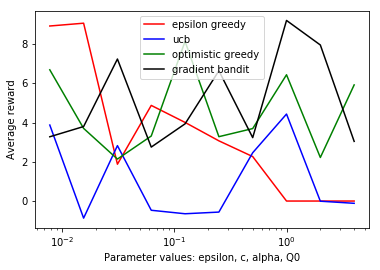

In [17]:
plot_bandits_parameter_comparison(bandits_parameter_comparison)

As expected the UCB method performs poorly for non-stationary reward distributions, and epsilon greedy and gradient bandit perform the best.